**Импорт библиотек и предобработка данных**

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Загрузка данных
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
features = ['A', 'B', 'C', 'D', 'E', 'F']

X_train = train_df.drop('target', axis=1)
y_train = train_df['target']
X_test = test_df.copy()

# Объединение данных для анализа (без учета целевой)
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['A', 'C', 'D', 'E', 'F']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['B', 'C'])
    ])

X_train_pp = preprocessor.fit_transform(train_df.drop('target', axis=1))
X_test_pp = preprocessor.transform(test_df)
X_train_pr, X_test_pr, y_train_pr, y_test_pr = train_test_split(
    X_train_pp, y_train, test_size=0.2, random_state=42
)

**Анализ**

* Так как мы не имеем никакой информации о данных с 6 датчиков, проведем исследование данных. \
Рассмотрим распределения данных, их взаимную корреляцию, и главное корреляцию с целевым параметром. \
На основе предварительного анализа датасета, сделана шипотеза, что столбцы B, C категориальные.

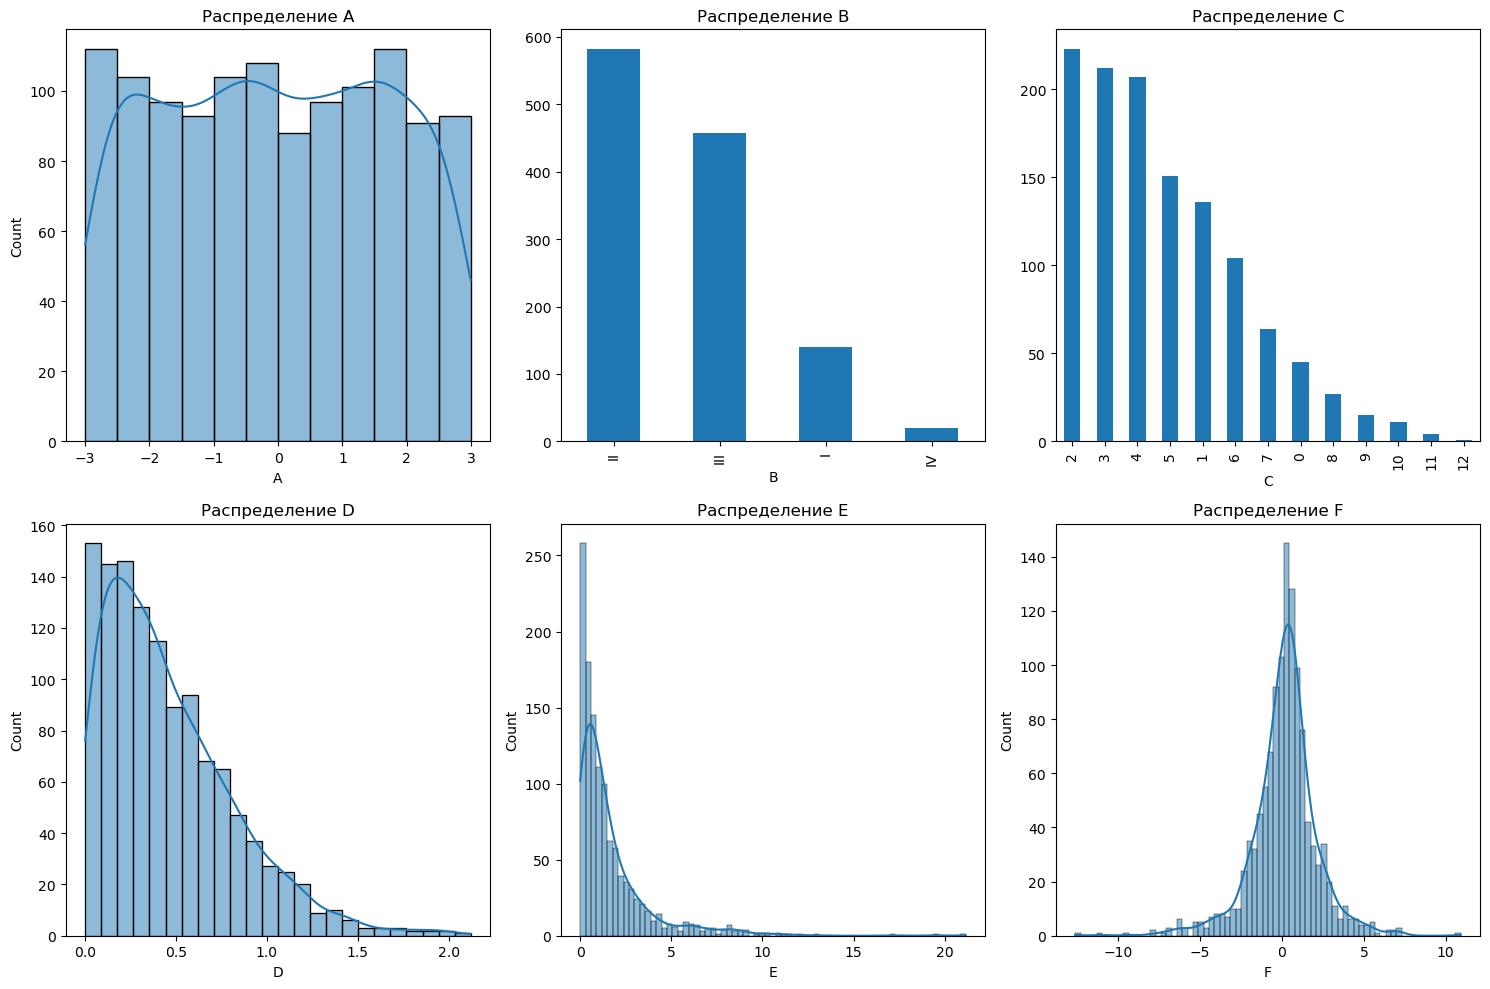

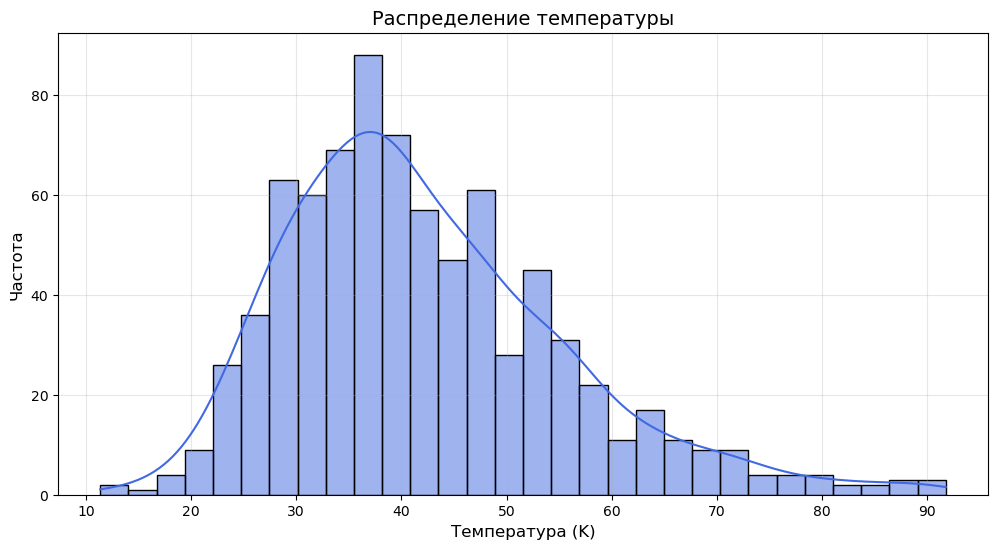

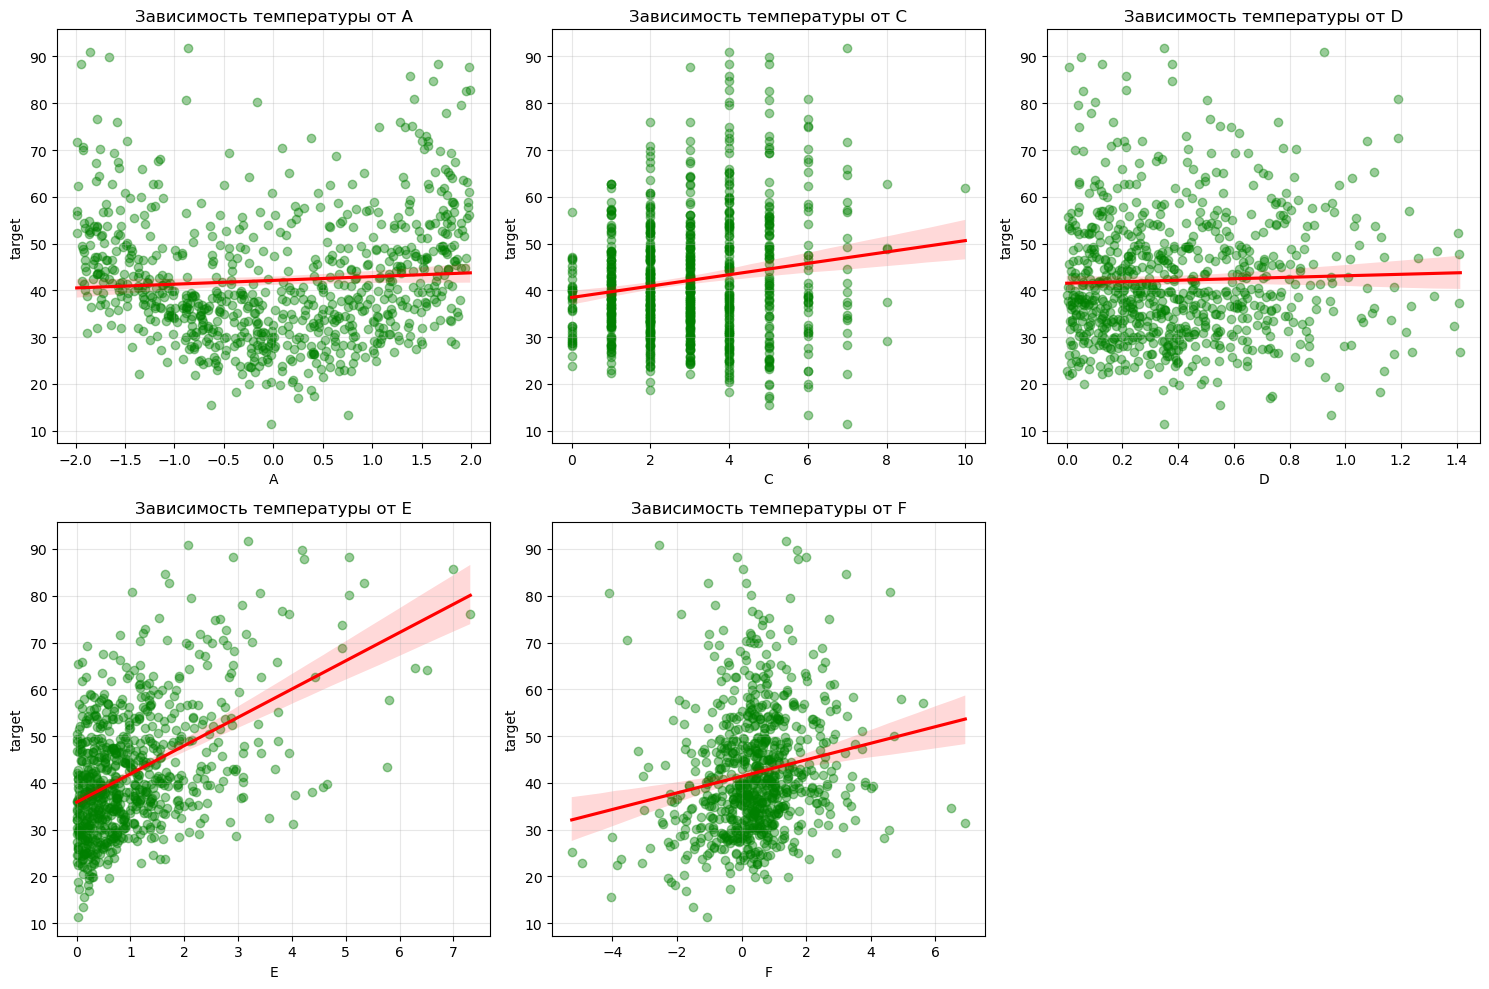

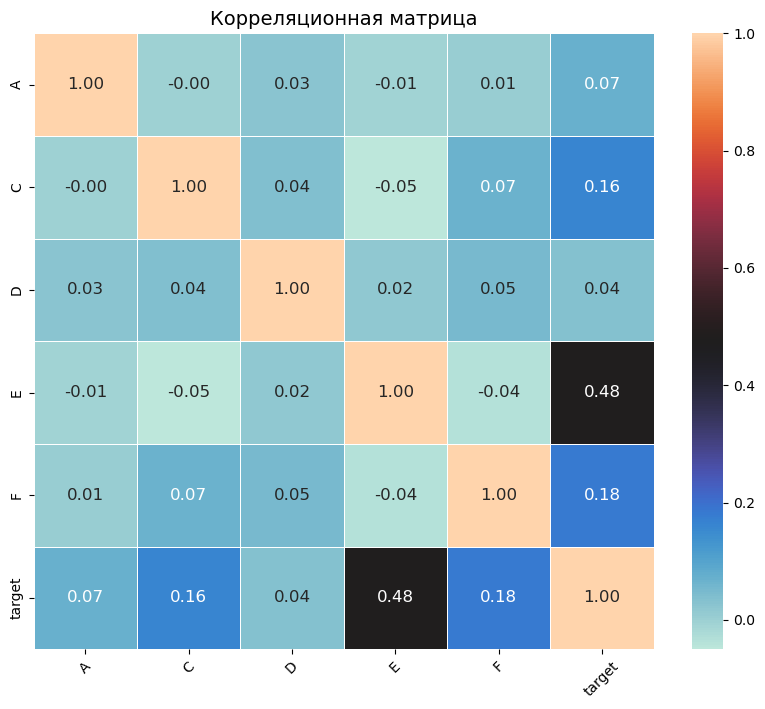

In [11]:

plt.figure(figsize=(15,10))
for i, col in enumerate(features, 1):
    plt.subplot(2,3,i)
    if col not in ['B', 'C']:
        sns.histplot(full_df[col], kde=True)
        
    else:
        full_df[col].value_counts().plot(kind='bar')
    plt.title(f'Распределение {col}')
plt.tight_layout()
plt.show()


# Распределение температуры
plt.figure(figsize=(12,6))
sns.histplot(train_df['target'], bins=30, kde=True, color='royalblue')
plt.title('Распределение температуры', fontsize=14)
plt.xlabel('Температура (K)', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(alpha=0.3)
plt.show()


plt.figure(figsize=(15,10))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(2,3,i)
    sns.regplot(
        x=col, 
        y='target', 
        data=train_df, 
        scatter_kws={'alpha':0.4, 'color':'green'}, 
        line_kws={'color':'red'}
    )
    plt.title(f'Зависимость температуры от {col}', fontsize=12)
    plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# 4. Матрица корреляций
corr_matrix = train_df[numeric_features + ['target']].corr()
plt.figure(figsize=(10,8))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    cmap='icefire', 
    fmt='.2f', 
    linewidths=0.5,
    annot_kws={'size':12}
)
plt.title('Корреляционная матрица', fontsize=14)
plt.xticks(rotation=45)
plt.show()

Из графиков выше видно, что:

- A имеет близкое к равномерному распределение
- B, C действительно категориальные признаки, при этом с увеличением номера категории ее частота резко падает
- Распределение F , близкое по форме к нормальному
- Наибольшее влияние на целевой параметр оказывают данные с датчика E

В первую очередь так как наибольшое влияние имеют числовые переменные попробуем применить **градиентный бустинг** и **случайный лес** \
Так как в датасете есть категориальные признаки \
закодируем их с помощью OneHotEncoder

In [21]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error

def calculate_rmse(model, X, y_true):
    y_pred = model.predict(X)
    return np.sqrt(mean_squared_error(y_true, y_pred))

#Случайный лес
rf_model = RandomForestRegressor(n_estimators=50, random_state=42)
rf_model.fit(X_train_pr, y_train_pr)
print(f'Random Forest RMSE: {calculate_rmse(rf_model, X_test_pr, y_test_pr):.2f}')

# Градиентный бустинг (XGBoost)
xgb_model = xgb.XGBRegressor(
    n_estimators=200, 
    learning_rate=0.1, 
    random_state=42
)
xgb_model.fit(X_train_pr, y_train_pr)
print(f'XGBoost RMSE: {calculate_rmse(xgb_model, X_test_pr, y_test_pr):.2f}')

# Тренировка на полном датасете
rf_model.fit(X_train_pp, y_train)
xgb_model.fit(X_train_pp, y_train)

predictions_rf = rf_model.predict(X_test_pp)
predictions_xgb = xgb_model.predict(X_test_pp)

test_df['target'] =  predictions_rf
test_df.to_csv('answers.csv', index=False)

test_df['target'] =  predictions_xgb
test_df.to_csv('answers1.csv', index=False)

Random Forest RMSE: 5.43
XGBoost RMSE: 5.15


В результате на части тренировочного датасета, модели
справляются отлично, то с тестовыми данными не справляются 
вовсе.

Попробуем применить подход из задачи h2 к данной.

In [23]:
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from sklearn.pipeline import Pipeline


kernel = ConstantKernel(1.0) * RBF(length_scale=1.0) + WhiteKernel(noise_level=0.1)

pipeline = Pipeline([
    ('gp', GaussianProcessRegressor(
        kernel=kernel,
        n_restarts_optimizer=10,
        alpha=0.1,
        normalize_y=True,
        random_state=42
    ))
])

pipeline.fit(X_train_pp, y_train)

y_pred, y_std = pipeline.predict(X_test_pp, return_std=True)

submission = pd.DataFrame({'target': y_pred})
submission.to_csv('answers.csv', index=False)

print(f"Оптимизированное ядро: {pipeline.named_steps['gp'].kernel_}")

Оптимизированное ядро: 8.66**2 * RBF(length_scale=9.11) + WhiteKernel(noise_level=1e-05)


C:\Users\user\AppData\Roaming\Python\Python312\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Результат уже куда лучше (0.67) но взаимосвязь с данными все равно не очевидно.

В таком случае попробуем собрать небольшую нейронную сеть для решения данной задачи

Чтобы избежать переобучения добавим несколько Dropout слоев

In [24]:
from tensorflow import keras
from tensorflow.keras import layers


input_dim = X_train_pp.shape[1]


model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(input_dim,)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=[keras.metrics.RootMeanSquaredError()]
)

history = model.fit(
    X_train_pp, y_train,
    epochs=300,
    batch_size=32,
    verbose=0
)
print(history.history.keys())
print(history.history['root_mean_squared_error'])

predictions = model.predict(X_test_pp)

test_df['target'] =  predictions.flatten()
test_df.to_csv('answers.csv', index=False)


C:\Users\user\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


dict_keys(['loss', 'root_mean_squared_error'])
[35.652652740478516, 15.096261024475098, 7.58262300491333, 6.8446736335754395, 6.616207599639893, 6.57384729385376, 6.2725324630737305, 6.5561017990112305, 5.733461380004883, 5.810794830322266, 6.4673261642456055, 5.810141563415527, 5.825810432434082, 6.103708267211914, 5.596064567565918, 5.667220115661621, 5.641582489013672, 6.12496280670166, 5.837603569030762, 6.134212017059326, 6.119775772094727, 5.7960991859436035, 5.862175464630127, 5.851870536804199, 5.162379264831543, 5.616003036499023, 6.026610851287842, 5.679929733276367, 5.279577732086182, 5.703726768493652, 5.583954334259033, 5.274945259094238, 5.4018707275390625, 5.8324198722839355, 5.305633544921875, 5.070817470550537, 5.428679943084717, 5.113792896270752, 5.45322847366333, 5.019789218902588, 5.17794942855835, 5.160853862762451, 5.3749165534973145, 5.117478370666504, 5.339704513549805, 5.29880428314209, 5.253446578979492, 4.809971332550049, 5.055980205535889, 5.054479598999023

>Этот метод позволил увеличит значение по метрике до 0.76

#### А если добавить в набор синтетические данные основанные на имеющихся? 
#### А также удалить всплески которые видны графиках зависимости температуры от переменной.



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

numeric_cols = ['A', 'C', 'D', 'E', 'F']
for col in numeric_cols:
    q1 = train_df[col].quantile(0.25)
    q3 = train_df[col].quantile(0.75)
    iqr = q3 - q1
    train_df[col] = train_df[col].clip(q1 - 1.5*iqr, q3 + 1.5*iqr)

def add_features(df, noise_level=0.01):
    df['E+F'] = df['E'] + df['F'] + np.random.normal(0, noise_level, len(df))
    df['E*F'] = df['E'] * df['F'] + np.random.normal(0, noise_level, len(df))
    df['E_sq'] = df['E']**2 + np.random.normal(0, noise_level, len(df))
    df['F_sq'] = df['F']**2 + np.random.normal(0, noise_level, len(df))
    return df

train_df = add_features(train_df)
test_df = add_features(test_df)
y_train = train_df['target']

features = ['A', 'C', 'D', 'E', 'F', 'E+F', 'E*F', 'E_sq', 'F_sq']
cat_features = ['B']

preprocessor = ColumnTransformer([
    ('num', RobustScaler(), features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

X_train_pp = preprocessor.fit_transform(train_df.drop('target', axis=1))
X_test_pp = preprocessor.transform(test_df)
X_train_pr, X_test_pr, y_train_pr, y_test_pr = train_test_split(
    X_train_pp, y_train, test_size=0.2, random_state=42
)

> Использование рассмотренных предобработок  данных не принесла прироста точности предсказаний модели.